In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from Higgs.tools.ImplementationUtils import (
    implementChainDecayLimit,
    fromHB5Table1,
    readHEPDataCsv
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions
from scipy.interpolate import griddata
import root_numpy
import tempfile
import requests
import ROOT
import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution

BR_Z_ll = 2 * 3.3658e-2  # from 2020 PDG


Welcome to JupyROOT 6.24/06


# CMS 13TeV LHC

## `pp > A/H > A H/A > ll bb`  [1911.03781](https://arxiv.org/abs/1911.03781)
The datagrid for this limit is a terrible mess, so we need to interpolate onto a reasonable regular grid.

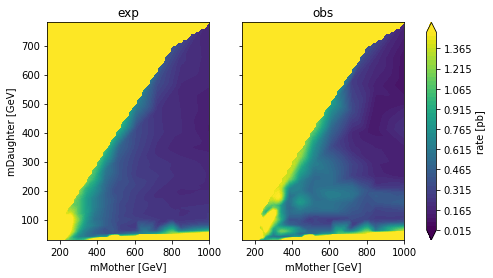

Looks good. Saving this to H_LHC13_CMS_36.json


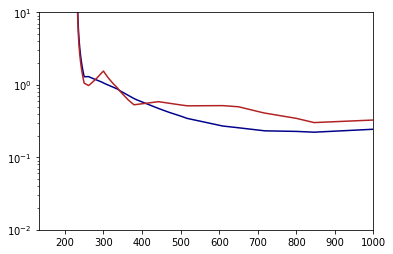

In [4]:
dfs = readHEPDataCsv(
    "https://www.hepdata.net/download/table/ins1764795/Figure%206/1/csv"
)
dfR = pd.merge(dfs[0], dfs[1], on=["m_A [GEV]", "m_H [GEV]"], validate="1:1",).rename(
    columns={
        "m_A [GEV]": "mDaughter",
        "m_H [GEV]": "mMother",
        r"Observed 95% upper limit [FB]": "obs",
        r"Expected 95% upper limit [FB]": "exp",
    }
)
# round the mass values near the edges for coverage
dfR.loc[dfR.mMother > 997, "mMother"] = 1e3


# interpolate onto a more reasonable grid
XX, YY = np.meshgrid(
    np.linspace(np.min(dfR.mMother), np.max(dfR.mMother), 63),
    np.linspace(np.min(dfR.mDaughter), np.max(dfR.mDaughter), 76),
)
df = pd.DataFrame(data={"mMother": XX.flatten(), "mDaughter": YY.flatten()})
df["exp"] = griddata(
    dfR[["mMother", "mDaughter"]],
    dfR.exp * 1e-3 / BR_Z_ll,  # fb to pb and remove Z>ll
    df[["mMother", "mDaughter"]],
    fill_value=1e6,
)

df["obs"] = griddata(
    dfR[["mMother", "mDaughter"]],
    dfR.obs * 1e-3 / BR_Z_ll,  # fb to pb and remove Z>ll
    df[["mMother", "mDaughter"]],
    fill_value=1e6,
)

limitFile = implementChainDecayLimit(
    "1911.03781",
    {"production": ["H"], "chain": "Z", "decay": ["bb"]},
    "https://doi.org/10.17182/hepdata.90710.v1/t7",
    df,
    # approx fit to Fig 4 (~half of the long axis)
    massResolution={
        "daughter": {"absolute": 0, "relative": 0.15},
        "mother": {"absolute": -20, "relative": 0.2},
    },
    contourfPlotArgs={
        "levels": np.linspace(1e-3 / BR_Z_ll, 0.1 / BR_Z_ll),
        "extend": "both",
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("Z", "h1", 1.0)
h1.setDecayWidth("bb", 1.0)
h1.setMass(130)
hm = np.unique(dfR.mMother)
r = np.linspace(0.01, 10)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


## `gg > A > Z hSM > ll bb` [1903.00941](https://arxiv.org/abs/1903.00941)


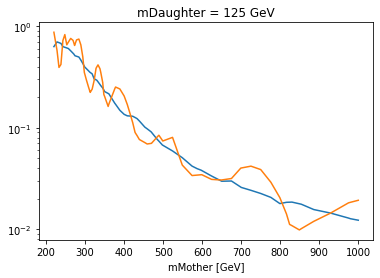

Looks good. Saving this to ggH_LHC13_CMS_36.json


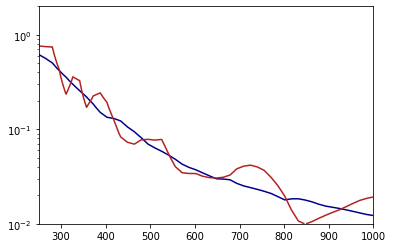

In [3]:
df = fromHB5Table1("180051_CMS_gg-A-Zh-Zbb_13TeV_35.9fb-1", "CMS").rename(
    columns={"m": "mMother"}
)
df["mDaughter"] = 125
limitFile = implementChainDecayLimit(
    "1903.00941",
    {"production": ["ggH"], "chain": "Z", "decay": ["bb"]},
    "Fig. 5 (left)",
    df,
    idSuffix=1,
    massResolution={
        "daughter": {
            "absolute": 30,  # signal region 100-140, conservative choice
            "relative": 0.0,
        },
        "mother": resolution.bb["highMass"],
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("Z", "h1", 1.0)
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
hm = np.linspace(250, 1000)
r = np.linspace(0.01, 2)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


## `bb > A > Z hSM > llbb`  [1903.00941](https://arxiv.org/abs/1903.00941)


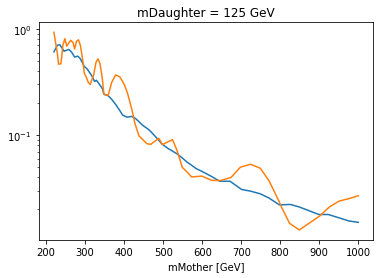

Looks good. Saving this to bbH_LHC13_CMS_36.json


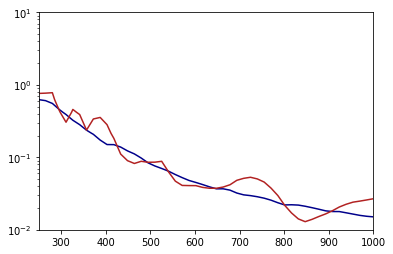

In [4]:
df = fromHB5Table1("180052_CMS_bb-A-Zh-Zbb_13TeV_35.9fb-1", "CMS").rename(
    columns={"m": "mMother"}
)
df["mDaughter"] = 125
limitFile = implementChainDecayLimit(
    "1903.00941",
    {"production": ["bbH"], "chain": "Z", "decay": ["bb"]},
    "Fig. 5 (right)",
    df,
    idSuffix=2,
    massResolution={
        "daughter": {
            "absolute": 30,  # signal region 100-140, conservative choice
            "relative": 0.0,
        },
        "mother": resolution.bb["highMass"],
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("Z", "h1", 1.0)
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
hm = np.linspace(250, 1000)
r = np.linspace(0.01, 10)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "bbH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


## high-mass `pp -> A -> Z hSM` [1807.02826](http://arxiv.org/abs/1807.02826)
The bbH and ggH limits are very similar, we take the weaker one and sum the cxns.

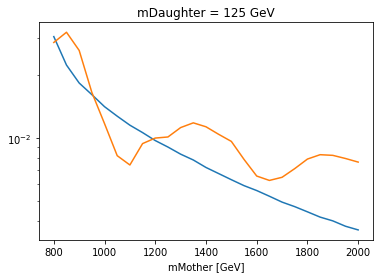

Looks good. Saving this to H_highM_LHC13_CMS_36.json


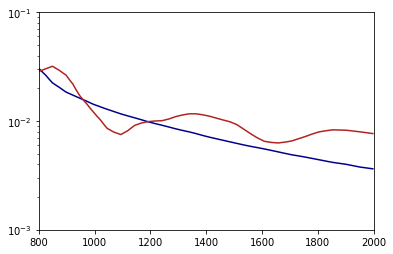

In [5]:
df = pd.DataFrame(
    {
        "mMother": np.arange(800, 2001, 50),
        "obs": [0.0286, 0.0320, 0.0262, 0.0165, 0.0117, 0.00822, 0.00742, 0.00939]
        + [0.00998, 0.0101, 0.0112, 0.0118, 0.0113, 0.0104, 0.00962, 0.00789, 0.00657]
        + [0.00626, 0.00648, 0.00713, 0.00792, 0.00831, 0.00825, 0.00797, 0.00766],
        "exp": [0.0305, 0.0223, 0.0183, 0.0161, 0.0141, 0.0127, 0.0115, 0.0106, 0.00971]
        + [0.00904, 0.00836, 0.00784, 0.00722, 0.00675, 0.00631, 0.00591, 0.00560]
        + [0.00526, 0.00493, 0.00469, 0.00443, 0.00418, 0.00401, 0.00378, 0.00363],
        "mDaughter": 125,
    }
)

limitFile = implementChainDecayLimit(
    1681436,
    {"production": ["H"], "chain": "Z", "decay": ["bb"]},
    "Fig. 8",
    df,
    massResolution={
        "daughter": {
            "absolute": 30,  # guess
            "relative": 0.0,
        },
        "mother": {
            "absolute": 0,
            "relative": 4e-2,
        },  # p 3, this probably uses the exact 125GeV
    },
    prefix="H_highM",
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("Z", "h1", 1.0)
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
hm = np.linspace(800, 2000)
r = np.linspace(1e-3, 0.1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


# CMS 8TeV LHC

## `H>ZA > llbb`  [1603.02991](https://arxiv.org/abs/1603.02991)

The data comes as a root histogram which needs some work.

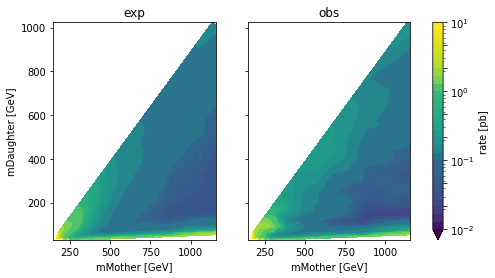

Looks good. Saving this to H_LHC8_CMS_20.json
[<Higgs.bounds.AppliedLimit limitId: 1603029912, obsRatio: 0.972, expRatio: 0.724, for: ["h1", ">", "h2"]>]


Warning in <TROOT::Append>: Replacing existing TH1: Graph (Potential memory leak).


In [6]:
def trilGridFromHist(hist):
    fullRes, edges = root_numpy.hist2array(hist, return_edges=True)
    assert np.allclose(fullRes, fullRes.T)
    res = np.tril(fullRes)
    posArgs = np.nonzero(res > 0)
    i0 = np.min(posArgs[0])
    i0T = np.min(posArgs[1])
    iE = np.max(posArgs[0]) - len(res[0])
    iET = np.max(posArgs[1]) - len(res[1])
    x = np.convolve(edges[0][i0:iE], np.ones(2) / 2.0, mode="valid")
    y = np.convolve(edges[1][i0T:iET], np.ones(2) / 2.0, mode="valid")
    return (res[i0:iE, i0T:iET], x, y)


r = requests.get(
    "https://twiki.cern.ch/twiki/pub/CMSPublic/Hig15001TWiki/ExpLimitXStimesBR_llbb.C"
)
r.encoding = "utf-8"
with tempfile.NamedTemporaryFile(mode="w") as f:
    f.write(
        r.text.replace(
            r'TText *text = new TText(500,500,"Kinematically forbidden");',
            r'TText *text2 = new TText(500,500,"Kinematically forbidden");',
        )
    )
    ROOT.gROOT.LoadMacro(f.name)
exp, xExp, yExp = trilGridFromHist(ROOT.h22_lt)

r = requests.get(
    "https://twiki.cern.ch/twiki/pub/CMSPublic/Hig15001TWiki/ObsLimitXStimesBR_llbb.C"
)
r.encoding = "utf-8"
with tempfile.NamedTemporaryFile(mode="w") as f:
    f.write(
        r.text.replace(
            r'TText *text = new TText(500,500,"Kinematically forbidden");',
            r'TText *text2 = new TText(500,500,"Kinematically forbidden");',
        )
    )
    ROOT.gROOT.LoadMacro(f.name)
obs, xObs, yObs = trilGridFromHist(ROOT.h24_lt)


assert np.allclose(xExp, xObs)
assert np.allclose(yExp, yObs)

exp = exp * 1e-3 / BR_Z_ll  # from fb to pb and correct for BR(Z>ll)
exp[exp == 0] = 1e6  # points where no limit is set
obs = obs * 1e-3 / BR_Z_ll  # from fb to pb and correct for BR(Z>ll)
obs[obs == 0] = 1e6  # points where no limit is set

XX, YY = np.meshgrid(xExp, yExp, indexing="ij")
df = pd.DataFrame(
    {
        "mMother": XX.flatten(order="C"),
        "mDaughter": YY.flatten(order="C"),
        "exp": exp.flatten(),
        "obs": obs.flatten(),
    }
)

limitFile = implementChainDecayLimit(
    "1603.02991",
    {"production": ["H"], "chain": "Z", "decay": ["bb"]},
    "https://twiki.cern.ch/twiki/bin/view/CMSPublic/Hig15001TWiki",
    df,
    idSuffix=2, # 1 is Ztautau
    massResolution={
        "daughter": resolution.bb["highMass"],  # from bb
        "mother": resolution.bb["highMass"],  # same abs at max mass
    },
    contourfPlotArgs={
        "levels": np.append(
            np.outer([1e-2, 0.1, 1.0], np.arange(1, 10, 1)).flatten(), 10
        ),
        "extend": "min",
        "norm": mcol.LogNorm(1e-2, 10),
    },
)

# no 1D limit to compare to, so just manually test some values
lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h1.setDecayWidth("Z", "h2", 1.0)
h2.setDecayWidth("bb", 1.0)

h1.setMass(900)
h2.setMass(150)
h1.setCxn("LHC8", "ggH", 3e-3 / BR_Z_ll)

res = lim.apply(pred)
print(res)


## `A>Zh125>llbb` [1504.04710](https://arxiv.org/abs/1504.04710)


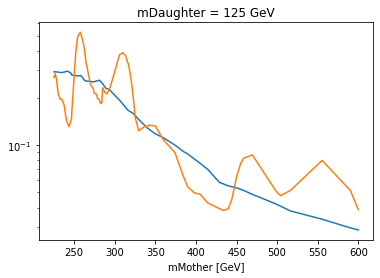

Looks good. Saving this to H_h125_LHC8_CMS_20.json


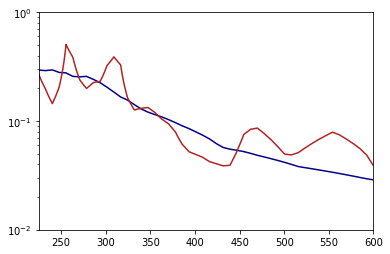

In [7]:
df = fromHB5Table1("14011_CMS_A-Zh-llbb_19.7fb-1", "CMS").rename(
    columns={"m": "mMother"}
)
df["mDaughter"] = 125

df.obs *= 1e-3 / BR_Z_ll  # from fb to pb and correct for BR(Z>ll)
df.exp *= 1e-3 / BR_Z_ll  # from fb to pb and correct for BR(Z>ll)


limitFile = implementChainDecayLimit(
    "1504.04710",
    {"production": ["H"], "chain": "Z", "decay": ["bb"]},
    "Fig. 3",
    df,
    prefix="H_h125",
    massResolution={
        "daughter": {
            "absolute": 30,  # signal region 90-140, conservative choice
            "relative": 0.0,
        },
        "mother": resolution.bb["highMass"],
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("Z", "h1", 1.0)
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
hm = np.linspace(225, 600)
r = np.linspace(0.01, 1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
